## What are the most common comorbidities in our claims data?

What is the distribution of the number of comorbidities for people having at least one chronic condition of interest?

What is the combination for a given chronic condition (include Chi-square as part of presented information)

Denominator: People who have 2 or more chronic conditions 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data = pd.read_csv('../../data/reshaped_med.csv')

In [3]:
# Conditions of interest
conditions = ['kidney', 'mental_disorder', 'bp', 'cardiovascular', 'diabetes', 'obesity', 'cancer', 'musculoskeletal', 'copd', 'cholesterol']

In [4]:
# def count_comorbidities(group):
#     count_df = pd.DataFrame()
#     count_df['member_id'] = group.head(1)['member_id']
#     count_df['num_comorbidities'] = group['total_conditions'].max() - 1
#     return count_df

In [9]:
# Get rows with at least 1 condition
with_condition = data.loc[data['total_conditions'] > 0]

condition_count = with_condition.groupby('member_id').agg({'total_conditions':'max'})[['total_conditions']].reset_index()
# Group by member ID and count comorbidities; 2 conditions = 1 comorbidity, etc.
# comorbidity_count = with_condition.groupby('member_id', as_index=False).apply(count_comorbidities)

In [10]:
condition_count['total_conditions'].describe()

count    14646.000000
mean         2.393077
std          1.396774
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: total_conditions, dtype: float64

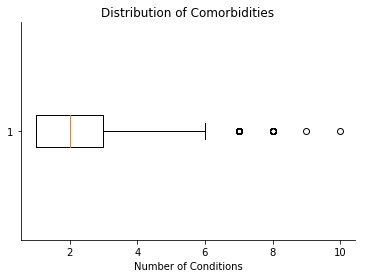

In [12]:
ax = plt.subplot()
ax.boxplot(condition_count['total_conditions'], vert=False)
ax.set_xlabel('Number of Conditions')
ax.set_title('Distribution of Comorbidities')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [41]:
cols = ['member_id', 'binary_asthma', 'binary_bp', 'binary_cancer', 'binary_cardiovascular', 'binary_cholesterol', 'binary_copd', 'binary_diabetes', 'binary_kidney', 'binary_mental_disorder', 'binary_musculoskeletal', 'binary_obesity', 'flag_comorbidity']
comorbid_count = data[cols]
comorbid_count = with_condition.groupby('member_id').agg({'binary_asthma':'max', 'binary_bp':'max', 'binary_cancer':'max', 'binary_cardiovascular':'max', 'binary_cholesterol':'max', 'binary_copd':'max', 'binary_diabetes':'max', 'binary_kidney':'max', 'binary_mental_disorder':'max', 'binary_musculoskeletal':'max', 'binary_obesity':'max', 'flag_comorbidity':'max'})
comorbid_count.head()

,binary_asthma,binary_bp,binary_cancer,binary_cardiovascular,binary_cholesterol,binary_copd,binary_diabetes,binary_kidney,binary_mental_disorder,binary_musculoskeletal,binary_obesity,flag_comorbidity
member_id,,,,,,,,,,,,
71002LEM4JV1PJFM4,0,0,1,0,0,0,0,0,0,0,0,0
710087KT90EY0DZUV,1,0,0,1,0,1,0,0,0,0,1,1
71008ADZ2VBBDM14C,0,0,0,0,1,0,1,0,0,0,1,1
7100UKNUMFS22SCRI,0,0,0,0,0,1,0,0,0,0,0,0
7100UNBYH5SYEX19X,0,0,0,0,1,0,0,0,0,1,0,1


In [42]:
def combination(condition):
    # Get all rows with at least 2 conditions
    comorbid = comorbid_count.loc[comorbid_count['flag_comorbidity'] == 1]
    
    # Get rows with and without given condition
    with_condition = comorbid.loc[comorbid_count['binary_' + condition] == 1]
    without_condition = comorbid.loc[comorbid_count['binary_' + condition] == 0]
    
    # Count members (with 2+ conditions) with given condition who also have other conditions of interest
    with_condition_counts = with_condition.groupby('member_id', as_index=False).apply(count_conditions)
    with_condition_counts = with_condition_counts.sum(axis=0)
    
    # Count members (with 2+ conditions) without given condition who have other conditions of interest
    without_condition_counts = without_condition.groupby('member_id', as_index=False).apply(count_conditions)
    without_condition_counts = without_condition_counts.sum(axis=0)
    
    # Lists for chi2 values, p-values, and number of members with both the given condition
    # and the current condition of interest
    chi2 = []
    p = []
    num_both = []
    
    # Calculate chi2 for each condition of interest in relation to given condition
    for c in conditions:
        both = with_condition_counts[c]
        condition_without_c = with_condition_counts[condition] - both
        without_condition_with_c = without_condition_counts[c]
        without_condition_without_c = len(without_condition) - without_condition_with_c
        
        c_arr = np.array([[both, condition_without_c], [without_condition_with_c, without_condition_without_c]])
        c_chi2, c_p, c_dof, c_ex= stats.chi2_contingency(c_arr)
        chi2.append(c_chi2)
        p.append(c_p)
        num_both.append(both)
    
    comorbidity_dict = {'conditions': conditions, 'chi2': chi2, 'p_value': p, 'num_members': num_both}
    return pd.DataFrame.from_dict(comorbidity_dict)

In [43]:
def count_conditions(group):
    counts = pd.DataFrame()
    
    counts['kidney'] = [1 if any(group['binary_kidney'] == 1) else 0]
    counts['mental_disorder'] = [1 if any(group['binary_mental_disorder'] == 1) else 0]
    counts['bp'] = [1 if any(group['binary_bp'] == 1) else 0]
    counts['cardiovascular'] = [1 if any(group['binary_cardiovascular'] == 1) else 0]
    counts['diabetes'] = [1 if any(group['binary_diabetes'] == 1) else 0]
    counts['obesity'] = [1 if any(group['binary_obesity'] == 1) else 0]
    counts['cancer'] = [1 if any(group['binary_cancer'] == 1) else 0]
    counts['musculoskeletal'] = [1 if any(group['binary_musculoskeletal'] == 1) else 0]
    counts['copd'] = [1 if any(group['binary_copd'] == 1) else 0]
    counts['cholesterol'] = [1 if any(group['binary_cholesterol'] == 1) else 0]

    return counts

In [70]:
comorbid_members = len(comorbid_count.loc[comorbid_count['flag_comorbidity'] == 1].index)
comorbid_members

9616

In [44]:
kidney_df = combination('kidney')
kidney_df

,conditions,chi2,p_value,num_members
0,kidney,9599.428549,0.000000e+00,620
1,mental_disorder,0.011252,9.155221e-01,75
2,bp,109.186079,1.477441e-25,517
3,cardiovascular,39.512074,3.260374e-10,386
4,diabetes,75.616354,3.444965e-18,427
5,obesity,0.131686,7.166898e-01,247
6,cancer,30.732231,2.962038e-08,117
7,musculoskeletal,0.199368,6.552312e-01,163
8,copd,21.664066,3.248193e-06,140
9,cholesterol,28.210080,1.088363e-07,429


In [83]:
kidney_df['pct_members'] = kidney_df['num_members']/comorbid_members
kidney_df = kidney_df.loc[kidney_df['conditions'] != 'kidney']
kidney_df['input_condition'] = 'kidney'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
mental_disorder_df = combination('mental_disorder')
mental_disorder_df

,conditions,chi2,p_value,num_members
0,kidney,0.011252,9.155221e-01,75
1,mental_disorder,9606.740191,0.000000e+00,1184
2,bp,52.212309,4.981291e-13,643
3,cardiovascular,1.096404,2.950565e-01,609
4,diabetes,43.480474,4.282110e-11,508
5,obesity,7.513402,6.124158e-03,419
6,cancer,3.467224,6.259628e-02,160
7,musculoskeletal,14.274354,1.580031e-04,376
8,copd,3.932701,4.735583e-02,212
9,cholesterol,20.428144,6.191258e-06,626


In [84]:
mental_disorder_df['pct_members'] = mental_disorder_df['num_members']/comorbid_members
mental_disorder_df = mental_disorder_df.loc[mental_disorder_df['conditions'] != 'mental_disorder']
mental_disorder_df['input_condition'] = 'mental_disorder'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
bp_df = combination('bp')
bp_df

,conditions,chi2,p_value,num_members
0,kidney,109.186079,1.477441e-25,517
1,mental_disorder,52.212309,4.981291e-13,643
2,bp,9611.670663,0.000000e+00,6135
3,cardiovascular,0.183221,6.686200e-01,3055
4,diabetes,88.581665,4.877895e-21,3407
5,obesity,3.410506,6.478257e-02,2354
6,cancer,28.694789,8.473142e-08,644
7,musculoskeletal,144.226163,3.170618e-33,1413
8,copd,3.528503,6.032221e-02,942
9,cholesterol,121.047911,3.730139e-28,3873


In [85]:
bp_df['pct_members'] = bp_df['num_members']/comorbid_members
bp_df = bp_df.loc[bp_df['conditions'] != 'bp']
bp_df['input_condition'] = 'bp'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
cardiovascular_df = combination('cardiovascular')
cardiovascular_df

,conditions,chi2,p_value,num_members
0,kidney,39.512074,3.260374e-10,386
1,mental_disorder,1.096404,2.950565e-01,609
2,bp,0.183221,6.686200e-01,3055
3,cardiovascular,9612.000414,0.000000e+00,4805
4,diabetes,48.692582,2.993967e-12,2323
5,obesity,0.832556,3.615345e-01,1855
6,cancer,5.125299,2.357951e-02,605
7,musculoskeletal,0.182491,6.692412e-01,1314
8,copd,95.290716,1.643823e-22,939
9,cholesterol,59.944268,9.758177e-15,2646


In [86]:
cardiovascular_df['pct_members'] = cardiovascular_df['num_members']/comorbid_members
cardiovascular_df = cardiovascular_df.loc[cardiovascular_df['conditions'] != 'cardiovascular']
cardiovascular_df['input_condition'] = 'cardiovascular'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
diabetes_df = combination('diabetes')
diabetes_df

,conditions,chi2,p_value,num_members
0,kidney,75.616354,3.444965e-18,427
1,mental_disorder,43.480474,4.282110e-11,508
2,bp,88.581665,4.877895e-21,3407
3,cardiovascular,48.692582,2.993967e-12,2323
4,diabetes,9611.994550,0.000000e+00,4992
5,obesity,26.522686,2.604613e-07,2074
6,cancer,48.552586,3.215500e-12,480
7,musculoskeletal,159.823230,1.236718e-36,1079
8,copd,11.880390,5.672807e-04,731
9,cholesterol,336.361906,3.955443e-75,3386


In [87]:
diabetes_df['pct_members'] = diabetes_df['num_members']/comorbid_members
diabetes_df = diabetes_df.loc[diabetes_df['conditions'] != 'diabetes']
diabetes_df['input_condition'] = 'diabetes'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
obesity_df = combination('obesity')
obesity_df

,conditions,chi2,p_value,num_members
0,kidney,0.131686,7.166898e-01,247
1,mental_disorder,7.513402,6.124158e-03,419
2,bp,3.410506,6.478257e-02,2354
3,cardiovascular,0.832556,3.615345e-01,1855
4,diabetes,26.522686,2.604613e-07,2074
5,obesity,9611.799734,0.000000e+00,3757
6,cancer,23.626220,1.169826e-06,369
7,musculoskeletal,36.326198,1.669052e-09,891
8,copd,6.470838,1.096588e-02,552
9,cholesterol,100.372443,1.262728e-23,1979


In [88]:
obesity_df['pct_members'] = obesity_df['num_members']/comorbid_members
obesity_df = obesity_df.loc[obesity_df['conditions'] != 'obesity']
obesity_df['input_condition'] = 'obesity'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
cancer_df = combination('cancer')
cancer_df

,conditions,chi2,p_value,num_members
0,kidney,30.732231,2.962038e-08,117
1,mental_disorder,3.467224,6.259628e-02,160
2,bp,28.694789,8.473142e-08,644
3,cardiovascular,5.125299,2.357951e-02,605
4,diabetes,48.552586,3.215500e-12,480
5,obesity,23.626220,1.169826e-06,369
6,cancer,9606.418246,0.000000e+00,1138
7,musculoskeletal,36.948612,1.212840e-09,395
8,copd,10.582004,1.141938e-03,219
9,cholesterol,24.114420,9.077798e-07,594


In [89]:
cancer_df['pct_members'] = cancer_df['num_members']/comorbid_members
cancer_df = cancer_df.loc[cancer_df['conditions'] != 'cancer']
cancer_df['input_condition'] = 'cancer'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
musculoskeletal_df = combination('musculoskeletal')
musculoskeletal_df

,conditions,chi2,p_value,num_members
0,kidney,0.199368,6.552312e-01,163
1,mental_disorder,14.274354,1.580031e-04,376
2,bp,144.226163,3.170618e-33,1413
3,cardiovascular,0.182491,6.692412e-01,1314
4,diabetes,159.823230,1.236718e-36,1079
5,obesity,36.326198,1.669052e-09,891
6,cancer,36.948612,1.212840e-09,395
7,musculoskeletal,9610.943836,0.000000e+00,2610
8,copd,9.744905,1.798205e-03,465
9,cholesterol,29.480387,5.648542e-08,1422


In [90]:
musculoskeletal_df['pct_members'] = musculoskeletal_df['num_members']/comorbid_members
musculoskeletal_df = musculoskeletal_df.loc[musculoskeletal_df['conditions'] != 'musculoskeletal']
musculoskeletal_df['input_condition'] = 'musculoskeletal'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
copd_df = combination('copd')
copd_df

,conditions,chi2,p_value,num_members
0,kidney,21.664066,3.248193e-06,140
1,mental_disorder,3.932701,4.735583e-02,212
2,bp,3.528503,6.032221e-02,942
3,cardiovascular,95.290716,1.643823e-22,939
4,diabetes,11.880390,5.672807e-04,731
5,obesity,6.470838,1.096588e-02,552
6,cancer,10.582004,1.141938e-03,219
7,musculoskeletal,9.744905,1.798205e-03,465
8,copd,9608.519340,0.000000e+00,1528
9,cholesterol,12.955732,3.189435e-04,837


In [102]:
copd_df['pct_members'] = copd_df['num_members']/comorbid_members
copd_df = copd_df.loc[copd_df['conditions'] != 'copd']
copd_df['input_condition'] = 'copd'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
cholesterol_df = combination('cholesterol')
cholesterol_df

,conditions,chi2,p_value,num_members
0,kidney,28.210080,1.088363e-07,429
1,mental_disorder,20.428144,6.191258e-06,626
2,bp,121.047911,3.730139e-28,3873
3,cardiovascular,59.944268,9.758177e-15,2646
4,diabetes,336.361906,3.955443e-75,3386
5,obesity,100.372443,1.262728e-23,1979
6,cancer,24.114420,9.077798e-07,594
7,musculoskeletal,29.480387,5.648542e-08,1422
8,copd,12.955732,3.189435e-04,837
9,cholesterol,9611.867602,0.000000e+00,5670


In [92]:
cholesterol_df['pct_members'] = cholesterol_df['num_members']/comorbid_members
cholesterol_df = cholesterol_df.loc[cholesterol_df['conditions'] != 'cholesterol']
cholesterol_df['input_condition'] = 'cholesterol'

D:\Users\vhsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [103]:
pcts = pd.concat([kidney_df, bp_df, mental_disorder_df, cardiovascular_df, diabetes_df, cancer_df, musculoskeletal_df, copd_df, cholesterol_df, obesity_df])
pcts.head()

,conditions,chi2,p_value,num_members,pct_members,input_condition
1,mental_disorder,0.011252,9.155221e-01,75,0.007800,kidney
2,bp,109.186079,1.477441e-25,517,0.053765,kidney
3,cardiovascular,39.512074,3.260374e-10,386,0.040141,kidney
4,diabetes,75.616354,3.444965e-18,427,0.044405,kidney
5,obesity,0.131686,7.166898e-01,247,0.025686,kidney


In [104]:
pcts = pcts.sort_values(by=['pct_members'], ascending=False)

In [107]:
pcts.iloc[::2, :]

,conditions,chi2,p_value,num_members,pct_members,input_condition
2,bp,121.047911,3.730139e-28,3873,0.402766,cholesterol
2,bp,88.581665,4.877895e-21,3407,0.354305,diabetes
4,diabetes,336.361906,3.955443e-75,3386,0.352121,cholesterol
2,bp,0.183221,6.686200e-01,3055,0.317700,cardiovascular
9,cholesterol,59.944268,9.758177e-15,2646,0.275166,cardiovascular
2,bp,3.410506,6.478257e-02,2354,0.244800,obesity
4,diabetes,48.692582,2.993967e-12,2323,0.241577,cardiovascular
4,diabetes,26.522686,2.604613e-07,2074,0.215682,obesity
5,obesity,100.372443,1.262728e-23,1979,0.205803,cholesterol
3,cardiovascular,0.832556,3.615345e-01,1855,0.192908,obesity
